# Data Science Demo: predicting Crime resolution in San Francisco

The City of San Francisco publishes historical crime events on their http://sfdata.gov website. 

I have loaded this dataset into HIVE. Let's use Spark to do some fun stuff with it!

## Setting Up Spark

First we create a SparkContext:

In [1]:
# Set up Spark Context
from pyspark import SparkContext, SparkConf

SparkContext.setSystemProperty('spark.executor.memory', '4g')
conf = SparkConf()
conf.set('spark.sql.autoBroadcastJoinThreshold', 200*1024*1024)  # 200MB for map-side joins 
conf.set('spark.executor.instances', 12)

sc = SparkContext('yarn-client', 'Spark-demo', conf=conf)

And now we create a HiveContext to enable Spark to access data from HIVE:

In [2]:
# Setup HiveContext
from pyspark.sql import HiveContext, Row
hc = HiveContext(sc)
hc.sql("use demo")
hc.sql("DESCRIBE crimes").show()

+-----------+---------+-------+
|   col_name|data_type|comment|
+-----------+---------+-------+
| incidentid|   string|   null|
|   category|   string|   null|
|description|   string|   null|
|  dayofweek|   string|   null|
|   date_str|   string|   null|
|       time|   string|   null|
|   district|   string|   null|
| resolution|   string|   null|
|    address|   string|   null|
|  longitude|   string|   null|
|   latitude|   string|   null|
|   location|   string|   null|
|       pdid|   string|   null|
+-----------+---------+-------+



Let's take a look at the dataset - first 5 rows:

In [3]:
crimes = hc.table("crimes")
crimes.limit(5).toPandas()

,incidentid,category,description,dayofweek,date_str,time,district,resolution,address,longitude,latitude,location,pdid
0,150331521,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Wednesday,04/22/2015,18:00,BAYVIEW,NONE,2000 Block of EVANS AV,-122.396315619126,37.7478113603031,"(37.7478113603031, -122.396315619126)",15033152106304
1,150341605,ASSAULT,ATTEMPTED SIMPLE ASSAULT,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160504114
2,150341605,ASSAULT,THREATS AGAINST LIFE,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160519057
3,150341605,OTHER OFFENSES,CRUELTY TO ANIMALS,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160528010
4,150341702,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Sunday,04/19/2015,12:03,MISSION,EXCEPTIONAL CLEARANCE,1100 Block of SOUTH VAN NESS AV,-122.416557578218,37.7547485110398,"(37.7547485110398, -122.416557578218)",15034170264020


## Exploring the Dataset

What are the different types of crime resolutions?

In [4]:
crimes.select("resolution").distinct().toPandas()

,resolution
0,LOCATED
1,JUVENILE DIVERTED
2,"ARREST, CITED"
3,NOT PROSECUTED
4,COMPLAINANT REFUSES TO PROSECUTE
5,CLEARED-CONTACT JUVENILE FOR MORE INFO
6,JUVENILE CITED
7,PROSECUTED FOR LESSER OFFENSE
8,EXCEPTIONAL CLEARANCE
9,JUVENILE BOOKED


Let's define a crime as 'resolved' if it has any string except "NONE" in the resolution column.

**Question**: How many crimes total in the dataset? How many resolved?

In [5]:
total = crimes.count()
num_resolved = crimes.filter(crimes.resolution != 'NONE').count()
print str(total) + " crimes total, out of which " + str(num_resolved) + " were resolved"

1750133 crimes total, out of which 700088 were resolved


Let's look at the longitude/latitude values in more detail. Spark provides the describe() function to see this some basic statistics of these columns:

In [6]:
c1 = crimes.select(crimes.longitude.cast("float").alias("long"), 
              crimes.latitude.cast("float").alias("lat"))
c1.describe().toPandas()

,summary,long,lat
0,count,1750133,1750133
1,mean,-122.42263853403858,37.771270995453996
2,stddev,0.030939621130535496,0.4727448638706336
3,min,-122.51364,37.70788
4,max,-120.5,90.0


Notice that the max values for longitude (-120.5) and latitude (90.0) seem strange. Those are not inside the SF area. Let's see how many bad values like this exist in the dataset: 

In [7]:
c2 = c1.filter('lat < 37 or lat > 38')
print c2.count()
c2.head(3)

143


[Row(long=-120.5, lat=90.0),
 Row(long=-120.5, lat=90.0),
 Row(long=-120.5, lat=90.0)]

Seems like this is a data quality issue where some data points just have a fixed (bad) value of -120.5, 90.

## Computing Neighborhoods

Now I create a new dataset called crimes2:
1. Without the points that have invalid longitude/latitude
2. I calculate the neighborhood associated with each long/lat (for each crime), using ESRI geo-spatial UDFs
3. Translate "resolution" to "resolved" (1.0 = resolved, 0.0 = unresolved)

In [8]:
hc.sql("add jar /home/jupyter/notebooks/jars/guava-11.0.2.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/spatial-sdk-json.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/esri-geometry-api.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/spatial-sdk-hive.jar")

hc.sql("create temporary function ST_Contains as 'com.esri.hadoop.hive.ST_Contains'")
hc.sql("create temporary function ST_Point as 'com.esri.hadoop.hive.ST_Point'")

cf = hc.sql("""
SELECT  date_str, time, longitude, latitude, resolution, category, district, dayofweek, description
FROM crimes
WHERE longitude < -121.0 and latitude < 38.0
""").repartition(50)
cf.registerTempTable("cf")

crimes2 = hc.sql("""
SELECT date_str, time, dayofweek, category, district, description, longitude, latitude,
       if (resolution == 'NONE',0.0,1.0) as resolved,
       neighborho as neighborhood 
FROM sf_neighborhoods JOIN cf
WHERE ST_Contains(sf_neighborhoods.shape, ST_Point(cf.longitude, cf.latitude))
""").cache()
crimes2.registerTempTable("crimes2")

In [9]:
crimes2.limit(5).toPandas()

,date_str,time,dayofweek,category,district,description,longitude,latitude,resolved,neighborhood
0,03/28/2015,21:00,Saturday,LARCENY/THEFT,RICHMOND,GRAND THEFT FROM PERSON,-122.513642064265,37.7784692199467,0,Seacliff
1,02/26/2015,09:45,Thursday,LARCENY/THEFT,RICHMOND,GRAND THEFT FROM LOCKED AUTO,-122.496761041371,37.7859619989064,0,Seacliff
2,02/09/2015,22:00,Monday,SUSPICIOUS OCC,RICHMOND,SUSPICIOUS OCCURRENCE,-122.509644693774,37.7752065367343,0,Seacliff
3,12/11/2014,21:00,Thursday,LARCENY/THEFT,RICHMOND,PETTY THEFT FROM LOCKED AUTO,-122.513642064265,37.7784692199467,0,Seacliff
4,08/24/2014,20:00,Sunday,VANDALISM,RICHMOND,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",-122.513642064265,37.7784692199467,0,Seacliff


**Question:** what is the percentage of crimes resolved in each neighborhood?

In [10]:
ngrp = crimes2.groupBy('neighborhood')
ngrp_pd = ngrp.avg('resolved').toPandas()
ngrp_pd['count'] = ngrp.count().toPandas()['count']
ngrp_pd.columns = ['neighborhood', '% resolved', 'count']
data = ngrp_pd.sort(columns = '% resolved', ascending=False)
print data.set_index('neighborhood').head(10)

                       % resolved   count
neighborhood                             
Downtown/Civic Center    0.571815  285122
Mission                  0.502114  190606
Bayview                  0.472574  119412
Haight Ashbury           0.445869   41898
Golden Gate Park         0.415417   15606
South of Market          0.392870  241230
Ocean View               0.384878   30724
Bernal Heights           0.372881   38881
Excelsior                0.371796   40810
Outer Mission            0.368532   37123


And as a bar chart:

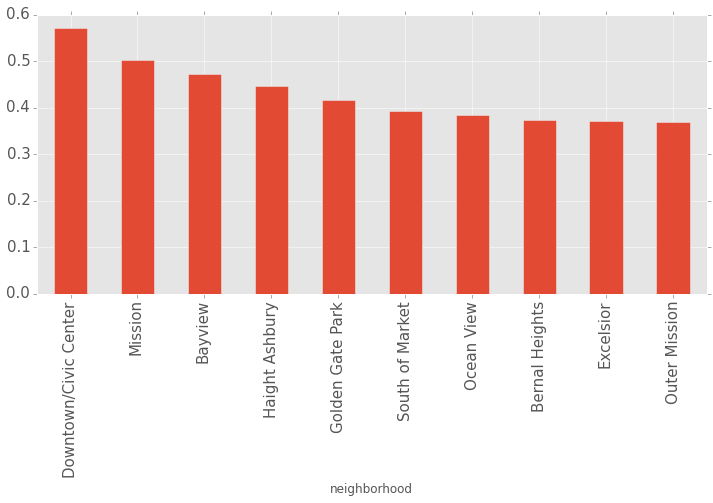

In [11]:
import matplotlib
matplotlib.style.use('ggplot')
data.iloc[:10].plot('neighborhood', '% resolved', kind='bar', legend=False, figsize=(12,5), fontsize=15)

Using the Python Folium package I draw an interactive map of San Francisco, and color-code each neighborhood with the percent of resolved crimes:

In [12]:
from IPython.display import HTML
import folium

map_width=1000
map_height=600
sf_lat = 37.77
sf_long = -122.4

def inline_map(m, width=map_width, height=map_height):
    m.create_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

map_sf = folium.Map(location=[sf_lat, sf_long], zoom_start=12, width=map_width, height=map_height)
map_sf.geo_json(geo_path='data/sfn.geojson', data=ngrp_pd,
                columns=['neighborhood', '% resolved'],
                key_on='feature.properties.neighborho',
                threshold_scale=[0, 0.3, 0.4, 0.5, 1.0],
                fill_color='OrRd', fill_opacity=0.6, line_opacity=0.6,
                legend_name='P(resolved)')

inline_map(map_sf)

## Preparing The Feature Matrix

First, some basic feature engineering work:
1. Extract year and month values from the date field
2. Extract hour from the time field

In [13]:
import pandas as pd

crimes3 = hc.sql("""
SELECT  cast(SUBSTR(date_str,7,4) as int) as year, 
        cast(SUBSTR(date_str,1,2) as int) as month, 
        cast(SUBSTR(time,1,2) as int) as hour,
        category, district, dayofweek, description, neighborhood, longitude, latitude, resolved
FROM crimes2
""").cache()
crimes3.limit(5).toPandas()

,year,month,hour,category,district,dayofweek,description,neighborhood,longitude,latitude,resolved
0,2015,4,11,LARCENY/THEFT,RICHMOND,Thursday,GRAND THEFT FROM LOCKED AUTO,Seacliff,-122.513642064265,37.7784692199467,0
1,2015,3,16,MISSING PERSON,RICHMOND,Tuesday,FOUND PERSON,Seacliff,-122.50363781312,37.7812059887529,1
2,2015,3,12,WARRANTS,RICHMOND,Friday,ENROUTE TO OUTSIDE JURISDICTION,Seacliff,-122.509225626818,37.7770424617966,1
3,2015,2,16,LARCENY/THEFT,RICHMOND,Monday,PETTY THEFT FROM LOCKED AUTO,Seacliff,-122.513642064265,37.7784692199467,0
4,2014,12,9,LARCENY/THEFT,RICHMOND,Saturday,GRAND THEFT FROM LOCKED AUTO,Seacliff,-122.513642064265,37.7784692199467,0


For this demo, I create a training set for my model from the data in years 2011-2013 and a testing/validation set from the data in year 2014.

In [14]:
trainData = crimes3.filter(crimes3.year>=2011).filter(crimes3.year<=2013).cache()
testData = crimes3.filter(crimes3.year==2014).cache()
print "training set has " + str(trainData.count()) + " instances"
print "test set has " + str(testData.count()) + " instances"

training set has 426306 instances
test set has 150155 instances


For convenience, I define a function to compute our classification metrics (we will use it later): precision, recall and accuracy

In [15]:
def eval_metrics(lap):
    tp = float(len(lap[(lap['label']==1) & (lap['prediction']==1)]))
    tn = float(len(lap[(lap['label']==0) & (lap['prediction']==0)]))
    fp = float(len(lap[(lap['label']==0) & (lap['prediction']==1)]))
    fn = float(len(lap[(lap['label']==1) & (lap['prediction']==0)]))
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    return {'precision': precision, 'recall': recall, 'accuracy': accuracy}

Next, I use Spark-ML to create a pipeline of transformation to generate the feature vector for each crime event:
- Converting each string variable (e.g., category, dayofweek, etc) to a categorical variable
- Converting the "description" field to a set of word features using Tokenizer() and HashingTF()
- Convert "resolved" (float) into a categorical variable "label"
- Assembling all the features into the a single feature vector (Vector Assembler)

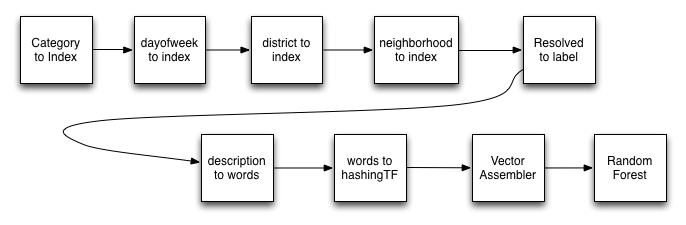

In [16]:
from IPython.display import Image
Image(filename='pipeline.png')

In [17]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Tokenizer, HashingTF
from pyspark.ml import Pipeline

inx1 = StringIndexer(inputCol="category", outputCol="cat-inx")
inx2 = StringIndexer(inputCol="dayofweek", outputCol="dow-inx")
inx3 = StringIndexer(inputCol="district", outputCol="dis-inx")
inx4 = StringIndexer(inputCol="neighborhood", outputCol="ngh-inx")
inx5 = StringIndexer(inputCol="resolved", outputCol="label")
parser = Tokenizer(inputCol="description", outputCol="words")
hashingTF = HashingTF(numFeatures=50, inputCol="words", outputCol="hash-inx")
vecAssembler = VectorAssembler(inputCols =["month", "hour", "cat-inx", "dow-inx", "dis-inx", "ngh-inx", "hash-inx"], 
                               outputCol="features")

## Predictive Models: Logistic Regression and Random Forest

Finish up the end-to-end pipeline and run the training set through it. The resulting model is in the model_lr variable, and is used to predict on the testData.

I use the previously defined eval_metrics() function to compute precision, recall, and accuracy

In [18]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.1, labelCol="label")
pipeline_lr = Pipeline(stages=[inx1, inx2, inx3, inx4, inx5, parser, hashingTF, vecAssembler, lr])
model_lr = pipeline_lr.fit(trainData)
results_lr = model_lr.transform(testData)

m = eval_metrics(results_lr.select("label", "prediction").toPandas())
print "precision = " + str(m['precision']) + ", recall = " + str(m['recall']) + ", accuracy = " + str(m['accuracy'])

precision = 0.758149655478, recall = 0.690560082214, accuracy = 0.807758649396


Similarly, create the same pipeline with the Random Forest classifier:

In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=250, maxDepth=5, maxBins=50, seed=42)
pipeline_rf = Pipeline(stages=[inx1, inx2, inx3, inx4, inx5, parser, hashingTF, vecAssembler, rf])
model_rf = pipeline_rf.fit(trainData)
results_rf = model_rf.transform(testData)

m = eval_metrics(results_rf.select("label", "prediction").toPandas())
print "precision = " + str(m['precision']) + ", recall = " + str(m['recall']) + ", accuracy = " + str(m['accuracy'])

precision = 0.807915479483, recall = 0.712893635763, accuracy = 0.834297892178


## Measure Model Accuracy Per Neighborhood

I would like to also show the accuracy of the model for each neighborhood.
For this, I compute the centroid for each neighborhood, using ESRI's ST_Centroid() HIVE UDF

In [20]:
hc.sql("add jar /home/jupyter/notebooks/jars/guava-11.0.2.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/esri-geometry-api.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/spatial-sdk-hive.jar")
hc.sql("add jar /home/jupyter/notebooks/jars/spatial-sdk-json.jar")

hc.sql("create temporary function ST_Centroid as 'com.esri.hadoop.hive.ST_Centroid'")
hc.sql("create temporary function ST_X as 'com.esri.hadoop.hive.ST_X'")
hc.sql("create temporary function ST_Y as 'com.esri.hadoop.hive.ST_Y'")

df_centroid = hc.sql("""
SELECT neighborho as neighborhood, 
       ST_X(ST_Centroid(sf_neighborhoods.shape)) as cent_longitude,
       ST_Y(ST_Centroid(sf_neighborhoods.shape)) as cent_latitude
FROM sf_neighborhoods
""")
df_centroid.cache()

DataFrame[neighborhood: string, cent_longitude: double, cent_latitude: double]

Now I draw a map, this time showing a marker with the accuracy for each neighborhood, using the results from the Random Forest model.

In [21]:
df = results_rf.select("neighborhood", "label", "prediction").toPandas()
map_sf = folium.Map(location=[sf_lat, sf_long], zoom_start=12, width=map_width, height=map_height)

n_list = results_rf.select("neighborhood").distinct().toPandas()['neighborhood'].tolist()  # list of neighborhoods
for n in df_centroid.collect():
    if n.neighborhood in n_list:
        m = eval_metrics(df[df['neighborhood']==n.neighborhood])
        map_sf.simple_marker([n.cent_latitude, n.cent_longitude], \
                             popup = n.neighborhood + ": accuracy = %.2f" % m['accuracy'])

inline_map(map_sf) 